In [86]:
from __future__ import division
import numpy as np
import pandas as pd
import math as math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import (StationaryKernelMixin,NormalizedKernelMixin,Kernel,Hyperparameter,squareform,pdist,cdist)
import scipy.spatial.distance as distance
import joblib
import matplotlib.pyplot as plt
import os

In [87]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Data\Updateddata.txt",names = columns)
datatab
x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']

# First Mass
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))

# Second Mass
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))

# Third Mass
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))

# Fourth Mass
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))

X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

In [88]:
indices = np.arange(X.shape[0])
X_trainval, X_test, D_trainval, D_test, E_trainval, E_test, indices_trainval, indices_test = train_test_split(X, D,E,indices, test_size=0.1, random_state=42)

In [ ]:
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  # Fix l1 bounds
guess_lmult = (1,1,1,1)
bounds_lsingle = (1e-4, 10.0)
ExpSinelbounds = (1e-2, 10.0)
guess_lsingle = 1.0
guess_signal_var = 1.0
bounds_signal_var = (1e-2, 20)
nu = 1.75
nu2 = 0.75
alpha = 1
periodicity = 2
periodictybounds = (1, 20)
noise_init_noerr = 1
noise_bounds_noerr = (1e-6, 1e6)
gamma = 1
E_var = E_trainval**2
##### bounds for noise level decided by the range(5,95)% of error. Tighter than no_error but not as tight as mean. Allowing for the model to have a decent bit of variation
p5, p95 = np.percentile(E_var, [5, 95])
noise_init_minmaxerr = np.mean(E_var)
noise_bounds_minmaxerr = (p5, p95)


RBFMat = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=(2,2,2,2), length_scale_bounds=(1,100)) + C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=(0.5,0.5,0.5,0.5), length_scale_bounds=(1e-2,10), nu=.75)
RBFLaplace = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=(1,1,1,1), length_scale_bounds=(0.1,100)) + C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=1, gamma_bounds = (0.5,5),metric='laplacian')
Mat_noerr = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu) + WhiteKernel(noise_level=noise_init_noerr, noise_level_bounds=noise_bounds_noerr)
Laplace_noerr = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=gamma, gamma_bounds=(0.1,50), metric='laplacian') + WhiteKernel(noise_level=noise_init_noerr, noise_level_bounds=noise_bounds_noerr)
RBF_noerr = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=guess_lmult, length_scale_bounds=(1e-2,10)) + WhiteKernel(noise_level=noise_init_noerr, noise_level_bounds=noise_bounds_noerr)
Mat_minmaxerr = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu) + WhiteKernel(noise_level=noise_init_minmaxerr, noise_level_bounds=noise_bounds_minmaxerr)
Laplace_minmaxerr = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=gamma, gamma_bounds=(0.1,50), metric='laplacian') + WhiteKernel(noise_level=noise_init_minmaxerr, noise_level_bounds=noise_bounds_minmaxerr)
RBF_minmaxerr = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=guess_lmult, length_scale_bounds=bounds_lmult) + WhiteKernel(noise_level=noise_init_minmaxerr, noise_level_bounds=noise_bounds_minmaxerr)

Kernels = {
    "RBFMat": RBFMat,
    "RBFLap": RBFLaplace,
    "Mat_noerr": Mat_noerr,
    "Laplace_noerr": Laplace_noerr,
    "RBF_noerr": RBF_noerr,
    "Mat_minmaxerr": Mat_minmaxerr,
    "Laplace_minmaxerr": Laplace_minmaxerr,
    "RBF_minmaxerr": RBF_minmaxerr
}

base_dir = r'C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final_gps'

for kernel_name, kernel_obj in tqdm(Kernels.items(), desc="Training and saving GPR models"):
    gpr = GaussianProcessRegressor(kernel=kernel_obj, normalize_y=True, n_restarts_optimizer=20, random_state=42)
    gpr.fit(X_trainval, D_trainval)
    # Save the model
    model_filename = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
    joblib.dump(gpr, model_filename)

Training and saving GPR models:   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
Training and saving GPR models:  12%|█▎        | 1/8 [22:35<2:38:07, 1355.36s/it]c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 0.1. Decreasing the boun

Processing kernels: 100%|██████████| 8/8 [00:00<00:00, 17.19it/s]


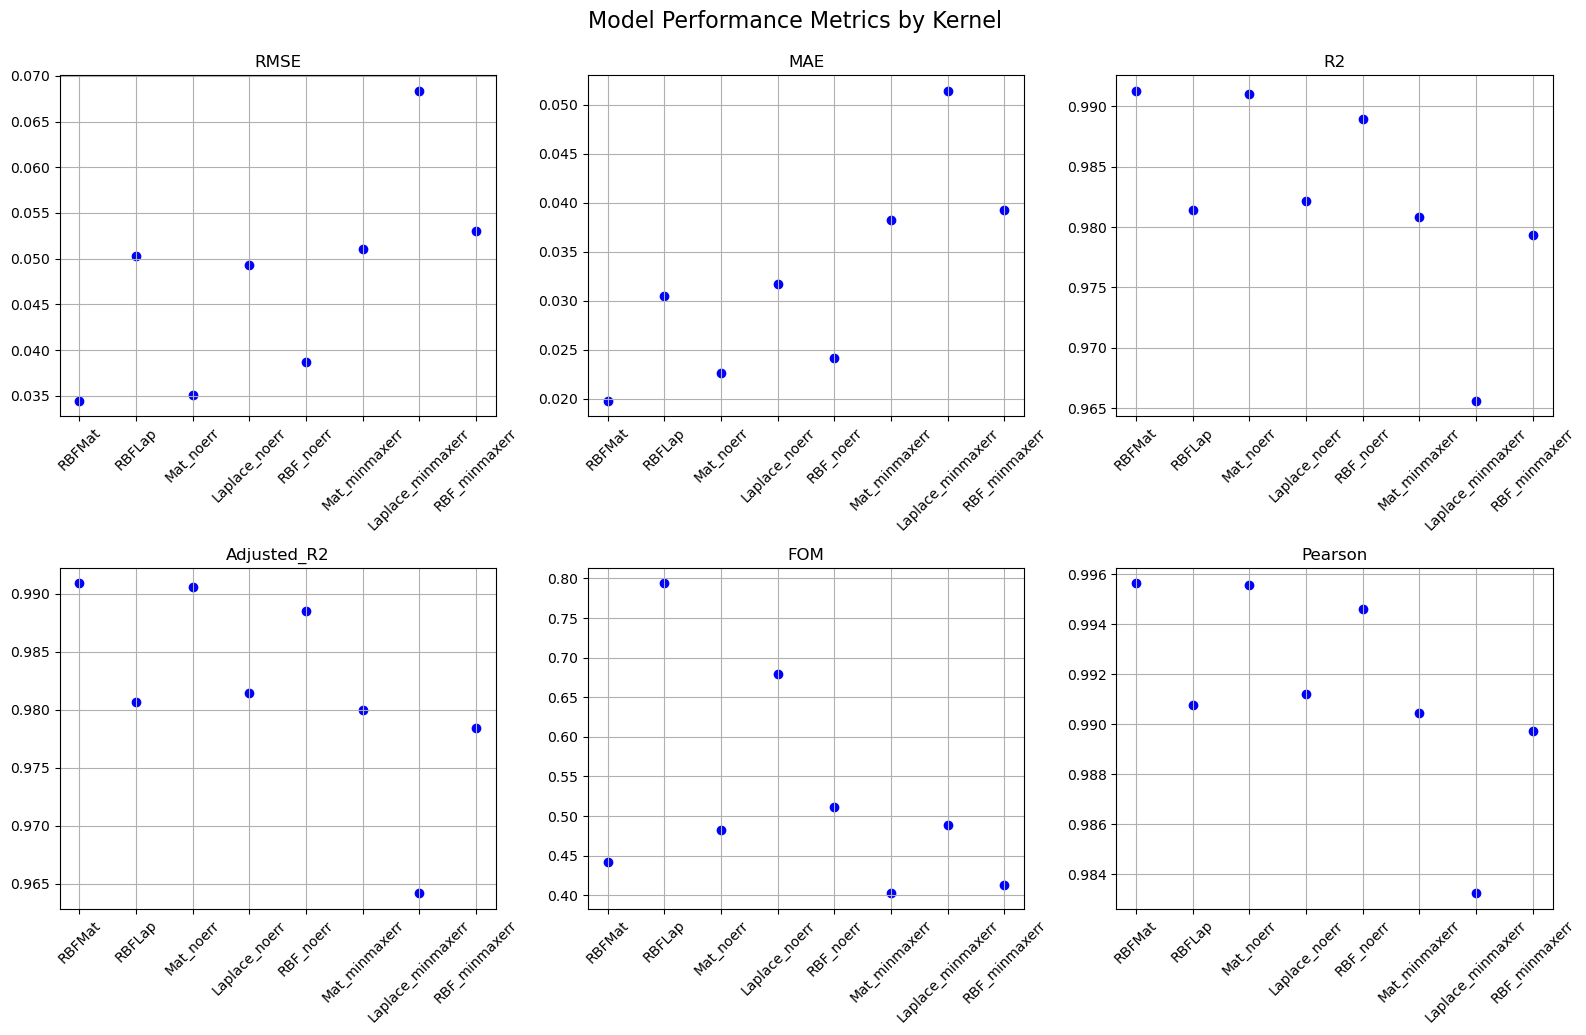

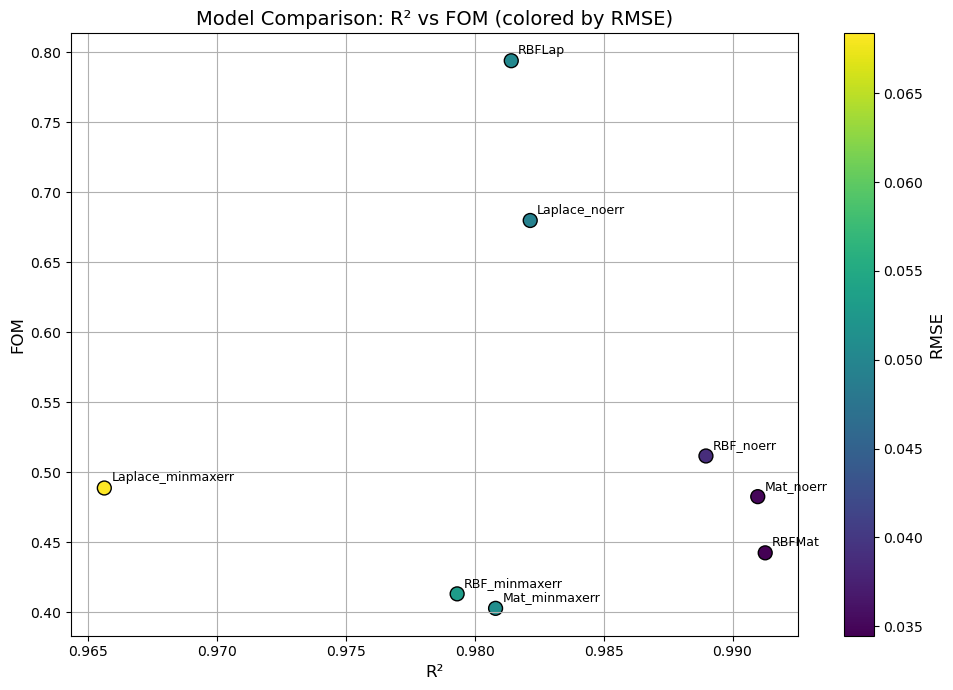

In [ ]:
import matplotlib.pyplot as plt

# Extract values
kernel_names = list(metrics["R2"].keys())
r2_values = [metrics["R2"][name] for name in kernel_names]
fom_values = [metrics["FOM"][name] for name in kernel_names]
rmse_values = [metrics["RMSE"][name] for name in kernel_names]

# Scatter plot
plt.figure(figsize=(10, 7))
sc = plt.scatter(r2_values, fom_values, c=rmse_values, cmap='viridis', s=100, edgecolor='k')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('RMSE', fontsize=12)

# Annotate points
for i, name in enumerate(kernel_names):
    plt.annotate(name, (r2_values[i], fom_values[i]), fontsize=9, xytext=(5, 5), textcoords='offset points')

# Labels and title
plt.xlabel("R²", fontsize=12)
plt.ylabel("FOM", fontsize=12)
plt.title("Model Comparison: R² vs FOM (colored by RMSE)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\metric_of_finalists_comparison",dpi=72, bbox_inches='tight')
plt.show()


Processing kernels: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


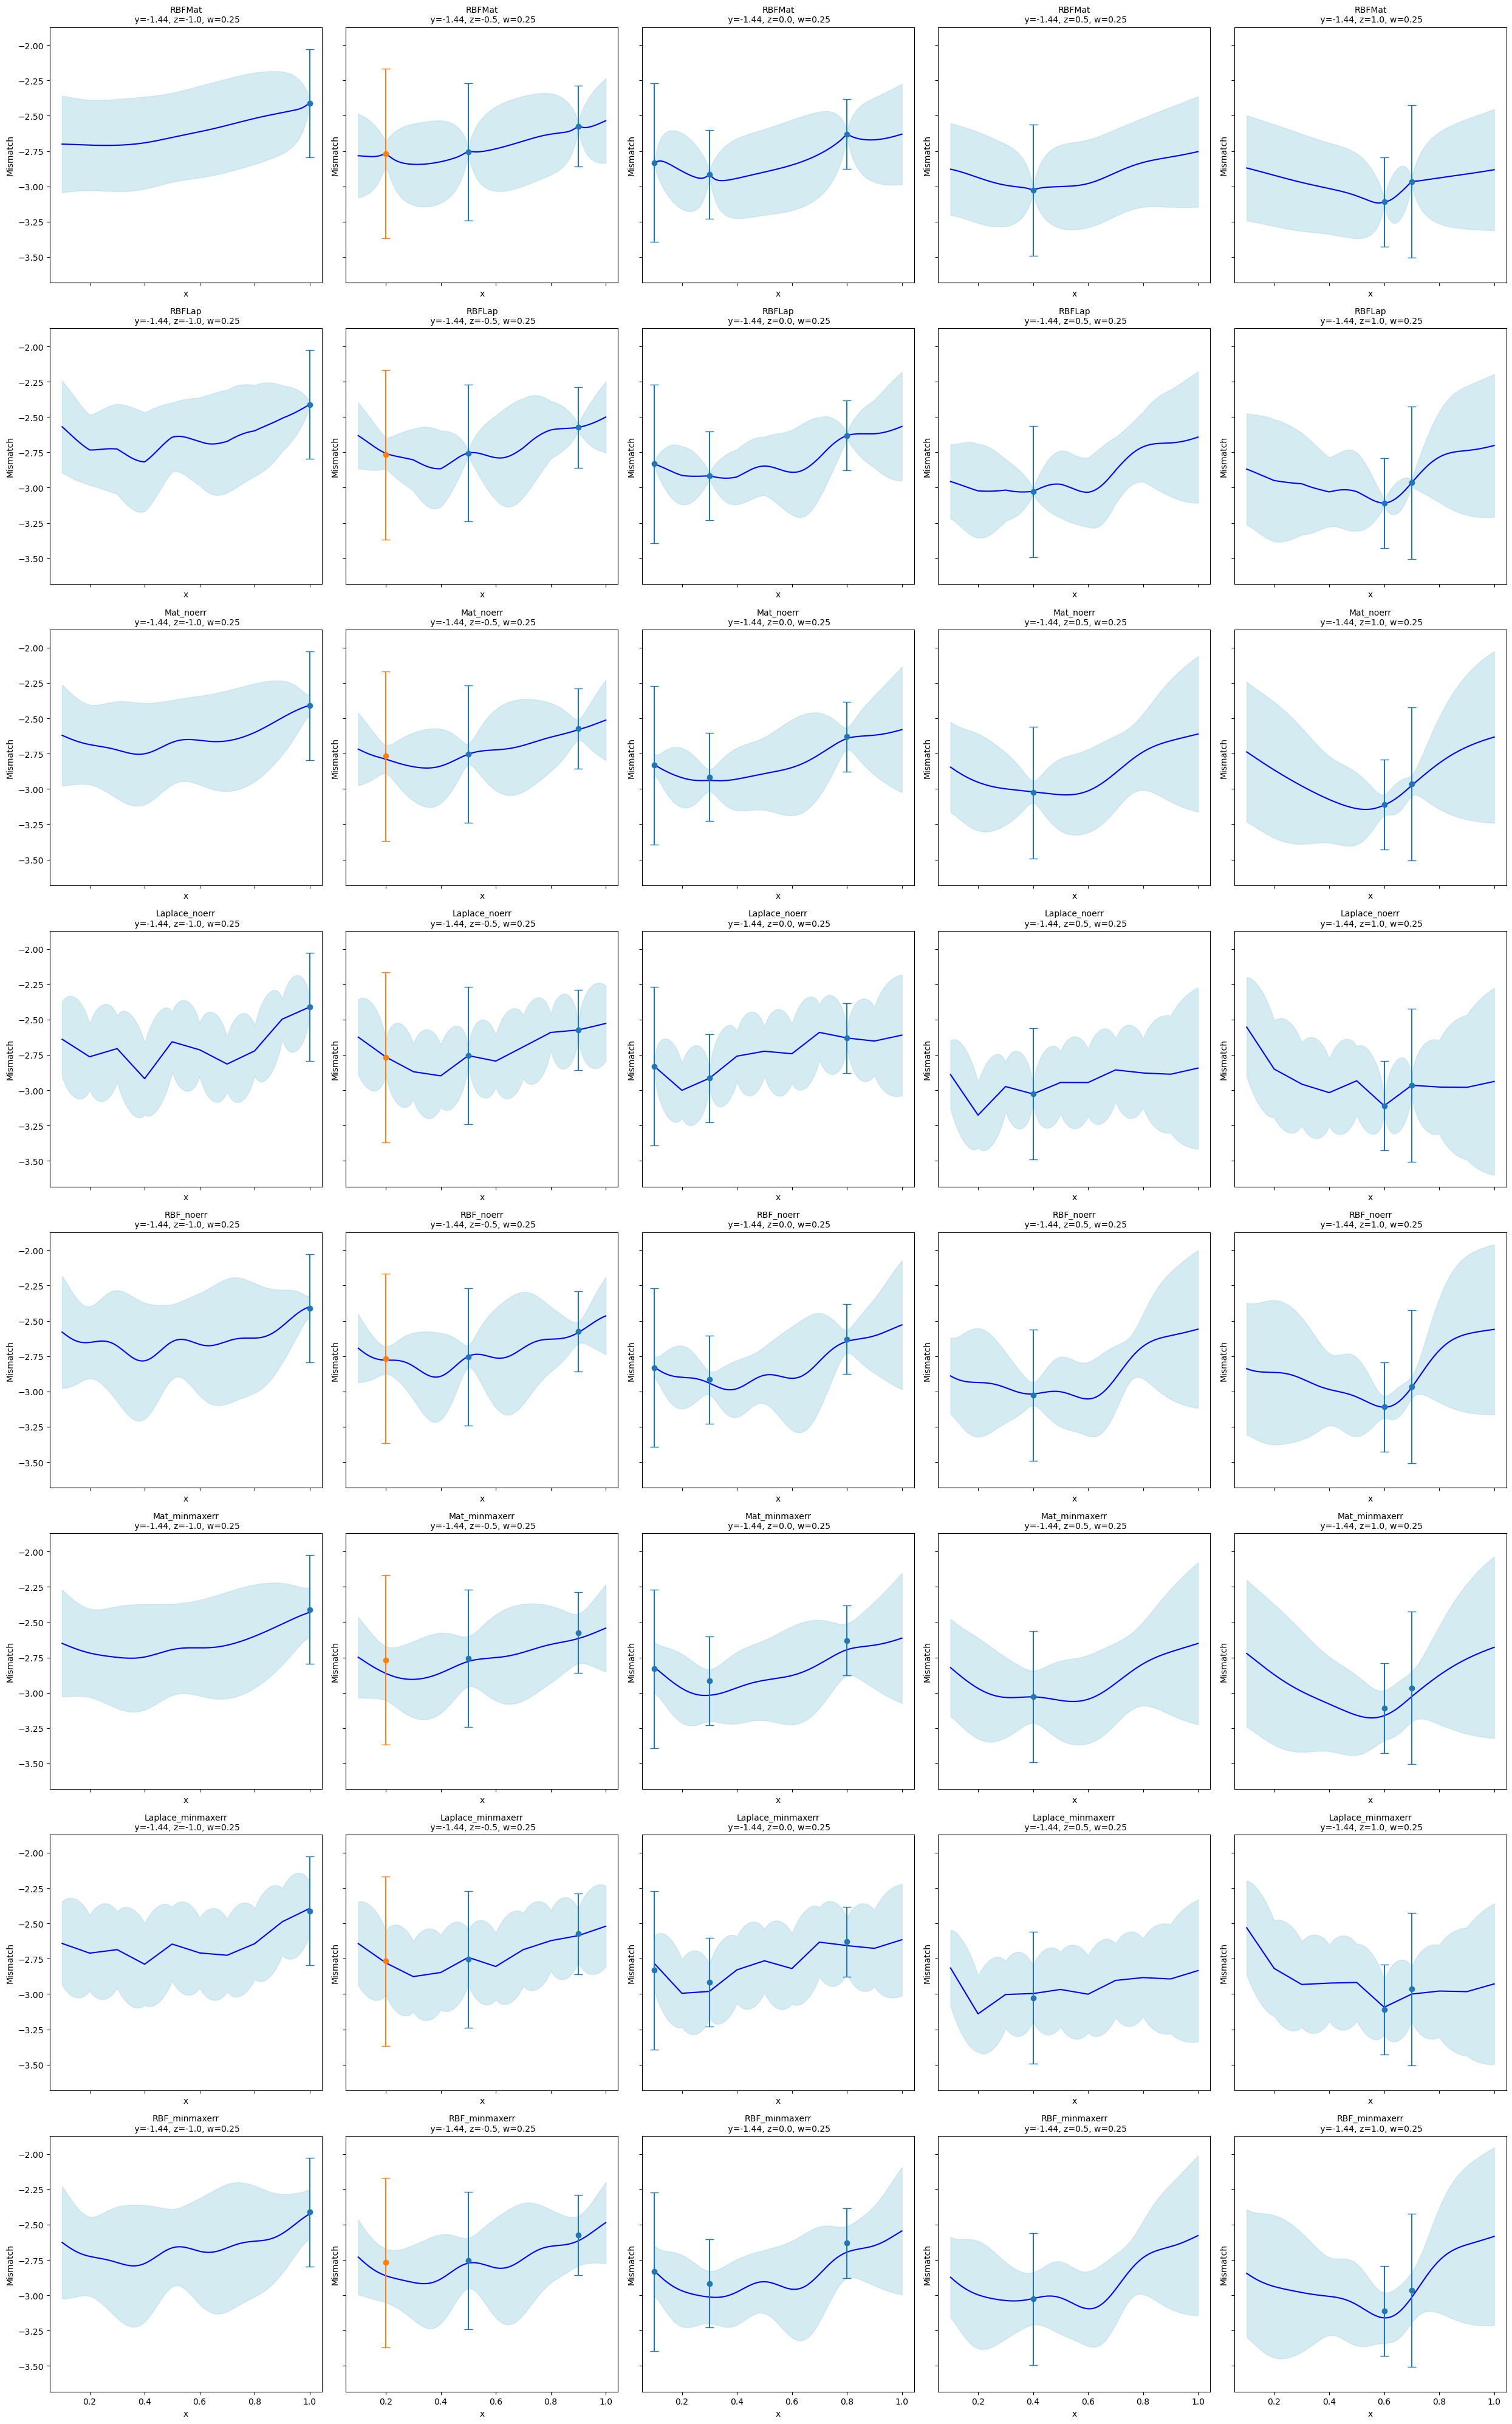

In [ ]:
# Data filtering: Only use indices <= 249
train1indices = indices_trainval[indices_trainval <= 249]
test1indices = indices_test[indices_test <= 249]
X1_train = X[train1indices]
X1_test = X[test1indices]
D1_train = D[train1indices]
D1_test = D[test1indices]
E1_train = E[train1indices]
E1_test = E[test1indices]

# Extract columns (assuming X has columns: x, y, z, w)
x1train = X1_train[:, 0]
y1train = X1_train[:, 1]
x1test = X1_test[:, 0]
y1test = X1_test[:, 1]
z1train = X1_train[:, 2]
z1test = X1_test[:, 2]

### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)

### Values data lies on
ypoints = np.linspace(-np.pi/2,np.pi/2,25)
xpoints = np.linspace(0.1,1,10)
zpoints = np.linspace(-1,1,5)
wpoints = np.linspace(0.25,1,4)

i = 1         # Choose a particular index for y
ypoint = ypoints[i]
j = 0         # Choose the first w value
wpoint = wpoints[j]

# Define z points (5 values)
zpoints = np.linspace(-1, 1, 5)

# Create a subplot grid: rows = number of kernels, columns = 5 (one for each z point)
num_kernels = len(Kernels)
fig, axes = plt.subplots(nrows=num_kernels, ncols=5, figsize=(25, 5 * num_kernels), sharex=True, sharey=True)

# Loop over kernels (each row)
for row, (kernel_name, kernel_obj) in enumerate(tqdm(Kernels.items(), desc="Processing kernels")):
    # Load the corresponding GPR model
    model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
    gpr_loaded = load(model_path)
    
    # Loop over each z value (each column)
    for col, zpoint in enumerate(zpoints):
        ax = axes[row, col]
        # Construct prediction inputs for given ypoint, zpoint, and fixed wpoint
        Xpred = np.column_stack((xdomain,np.full(xdomain.shape, ypoint),np.full(xdomain.shape, zpoint),np.full(xdomain.shape, wpoint)))
        
        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)
        
        # Plot the GP prediction (mean and credible interval)
        ax.plot(xdomain, pred_mean, color='blue')
        ax.fill_between(xdomain, pred_mean - 2*pred_std, pred_mean + 2*pred_std,color='lightblue', alpha=0.5)
        
        # Find training and test points near the current ypoint and zpoint
        indtrain = np.isclose(y1train, ypoint, atol=0.05) & np.isclose(z1train, zpoint, atol=0.05)
        indtest  = np.isclose(y1test,  ypoint, atol=0.05) & np.isclose(z1test,  zpoint, atol=0.05)
        
        # Overlay training and test data
        ax.errorbar(x1train[indtrain].ravel(), D1_train[indtrain].ravel(),
                    yerr=E1_train[indtrain].ravel(), fmt='o', capsize=5, color='#1f77b4')
        ax.errorbar(x1test[indtest].ravel(), D1_test[indtest].ravel(),
                    yerr=E1_test[indtest].ravel(), fmt='o', capsize=5, color='#ff7f0e')
        
        # Set subplot title with kernel and current parameters
        ax.set_title(f"{kernel_name}\n y={np.round(ypoint,2)}, z={np.round(zpoint,2)}, w={np.round(wpoint,2)}", fontsize=10)
        ax.set_xlabel("x", fontsize=10)
        ax.set_ylabel("Mismatch", fontsize=10)

# Add legend only once in the top-left subplot
#axes[0, 0].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\final_gps_ycuts",dpi=72, bbox_inches='tight')
plt.show()

Processing kernels: 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


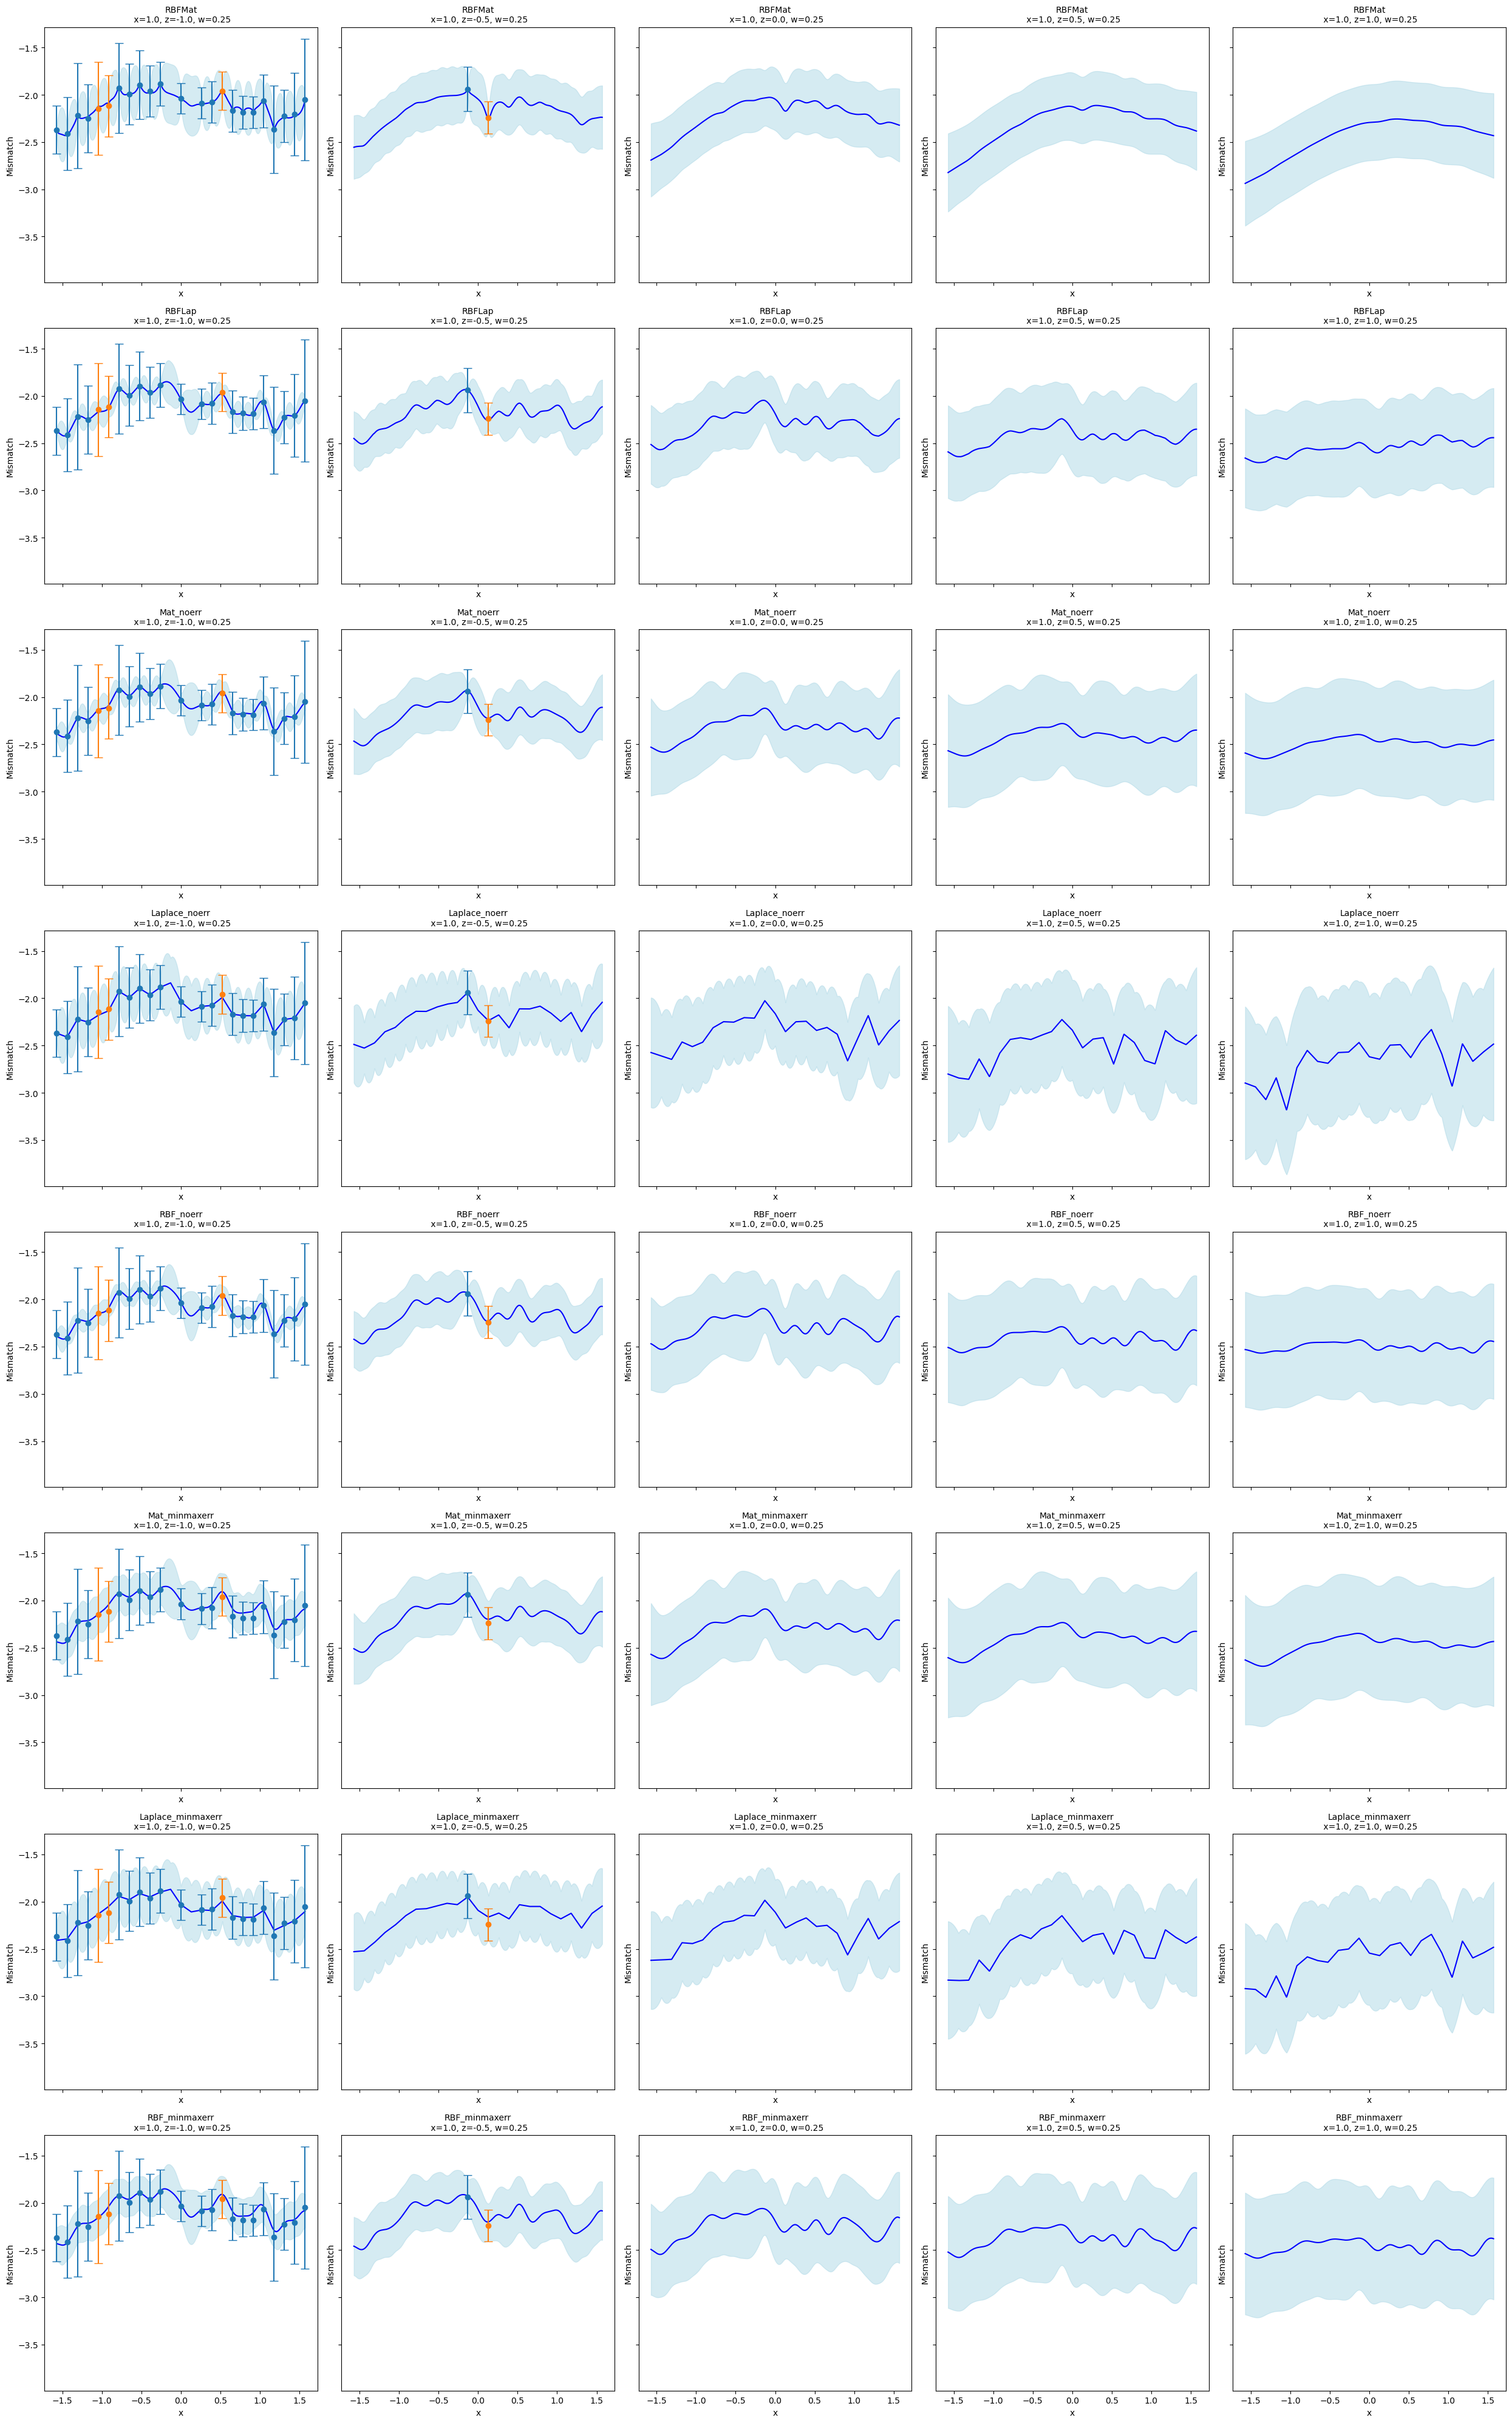

In [ ]:
# Data filtering: Only use indices <= 249
train1indices = indices_trainval[indices_trainval <= 249]
test1indices = indices_test[indices_test <= 249]
X1_train = X[train1indices]
X1_test = X[test1indices]
D1_train = D[train1indices]
D1_test = D[test1indices]
E1_train = E[train1indices]
E1_test = E[test1indices]

# Extract columns (assuming X has columns: x, y, z, w)
x1train = X1_train[:, 0]
y1train = X1_train[:, 1]
x1test = X1_test[:, 0]
y1test = X1_test[:, 1]
z1train = X1_train[:, 2]
z1test = X1_test[:, 2]

### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)

### Values data lies on
ypoints = np.linspace(-np.pi/2,np.pi/2,25)
xpoints = np.linspace(0.1,1,10)
zpoints = np.linspace(-1,1,5)
wpoints = np.linspace(0.25,1,4)

i = 9          
xpoint = xpoints[i]

j = 0         # Choose the first w value
wpoint = wpoints[j]



# Create a subplot grid: rows = number of kernels, columns = 5 (one for each z point)
num_kernels = len(Kernels)
fig, axes = plt.subplots(nrows=num_kernels, ncols=5, figsize=(25, 5 * num_kernels), sharex=True, sharey=True)

# Loop over kernels (each row)
for row, (kernel_name, kernel_obj) in enumerate(tqdm(Kernels.items(), desc="Processing kernels")):
    # Load the corresponding GPR model
    model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
    gpr_loaded = load(model_path)
    
    # Loop over each z value (each column)
    for col, zpoint in enumerate(zpoints):
        ax = axes[row, col]
        # Construct prediction inputs for given ypoint, zpoint, and fixed wpoint
        Xpred = np.column_stack((np.full(ydomain.shape,xpoint), ydomain,np.full(ydomain.shape, zpoint),np.full(ydomain.shape, wpoint)))
        
        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)
        
        # Plot the GP prediction (mean and credible interval)
        ax.plot(ydomain, pred_mean, color='blue')
        ax.fill_between(ydomain, pred_mean - 2*pred_std, pred_mean + 2*pred_std,color='lightblue', alpha=0.5)
        
        # Find training and test points near the current ypoint and zpoint
        indtrain = np.isclose(x1train, xpoint, atol=0.05) & np.isclose(z1train, zpoint, atol=0.05)
        indtest  = np.isclose(x1test,  xpoint, atol=0.05) & np.isclose(z1test,  zpoint, atol=0.05)
        
        # Overlay training and test data
        ax.errorbar(y1train[indtrain].ravel(), D1_train[indtrain].ravel(),
                    yerr=E1_train[indtrain].ravel(), fmt='o', capsize=5, color='#1f77b4')
        ax.errorbar(y1test[indtest].ravel(), D1_test[indtest].ravel(),
                    yerr=E1_test[indtest].ravel(), fmt='o', capsize=5, color='#ff7f0e')
        
        # Set subplot title with kernel and current parameters
        ax.set_title(f"{kernel_name}\n x={np.round(xpoint,2)}, z={np.round(zpoint,2)}, w={np.round(wpoint,2)}", fontsize=10)
        ax.set_xlabel("x", fontsize=10)
        ax.set_ylabel("Mismatch", fontsize=10)

# Add legend only once in the top-left subplot
#axes[0, 0].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\final_gps_xcuts",dpi=72, bbox_inches='tight')
plt.show()

#### Focusing on RBF-Mat

1.53**2 * RBF(length_scale=[1, 1.51, 1.38, 1.36]) + 0.455**2 * Matern(length_scale=[0.0996, 0.0582, 0.414, 2.31], nu=0.75)


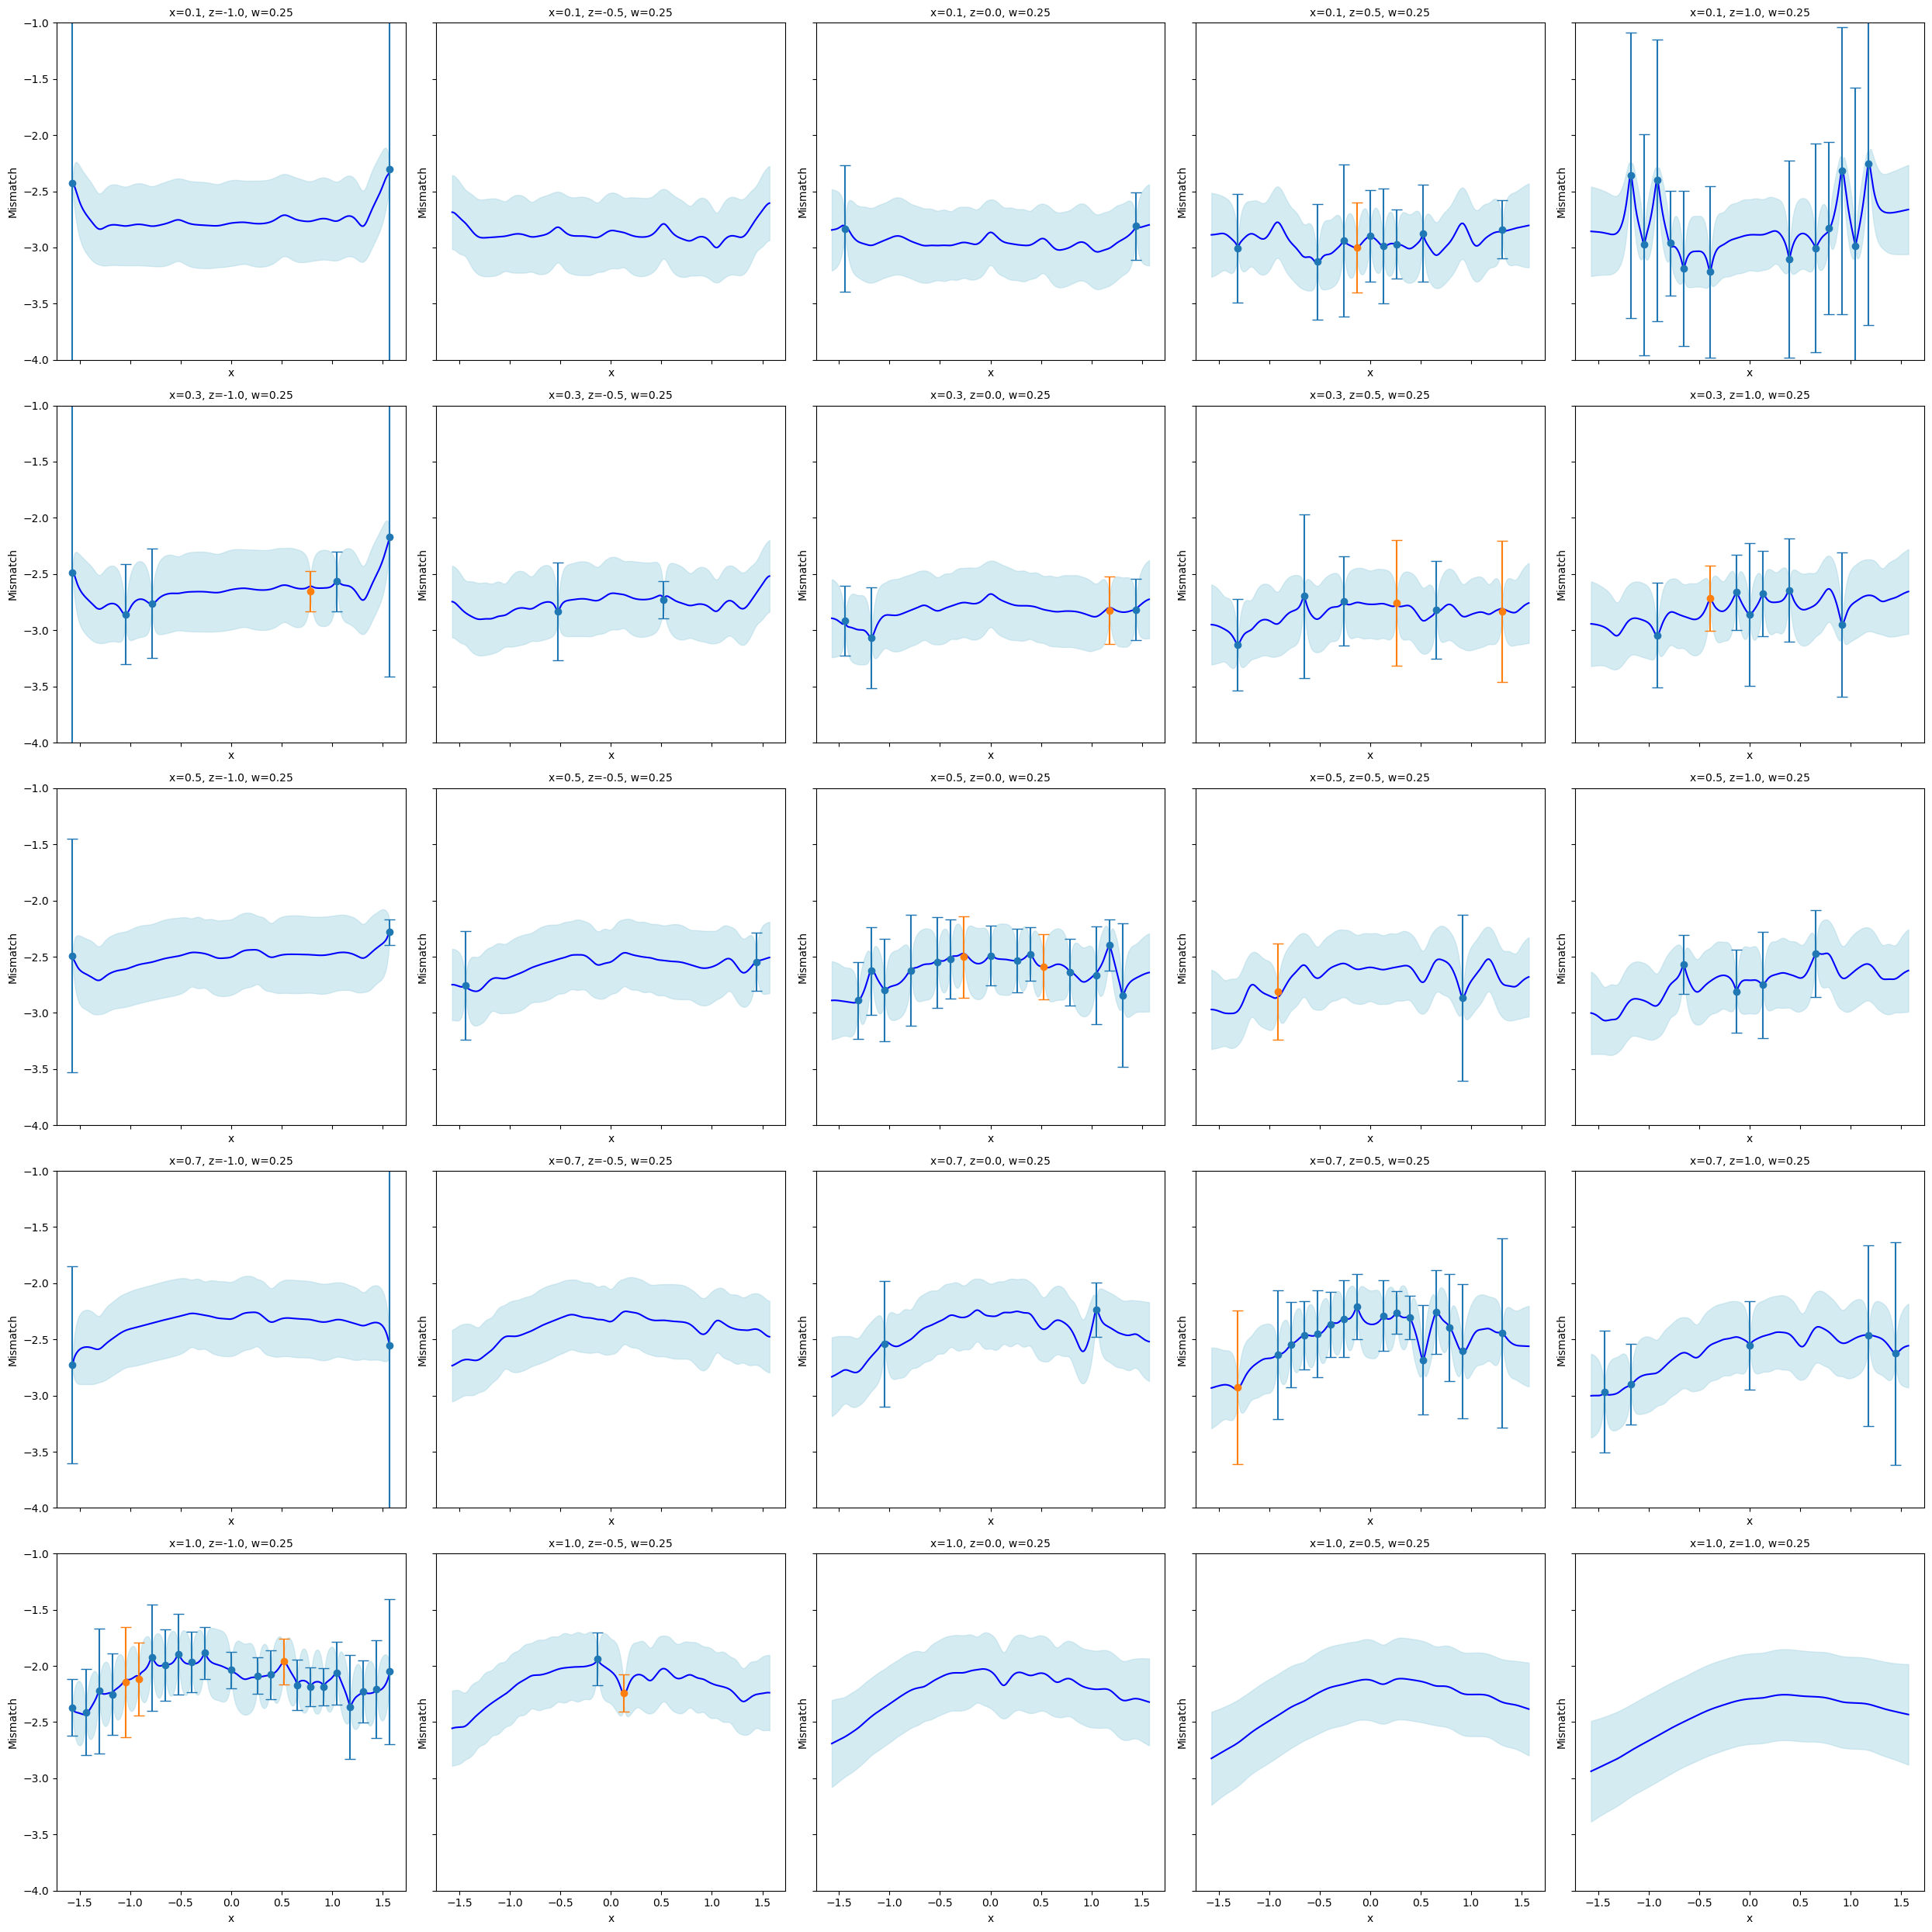

In [ ]:
# Data filtering: Only use indices <= 249
train1indices = indices_trainval[indices_trainval <= 249]
test1indices = indices_test[indices_test <= 249]
X1_train = X[train1indices]
X1_test = X[test1indices]
D1_train = D[train1indices]
D1_test = D[test1indices]
E1_train = E[train1indices]
E1_test = E[test1indices]

# Extract columns (assuming X has columns: x, y, z, w)
x1train = X1_train[:, 0]
y1train = X1_train[:, 1]
x1test = X1_test[:, 0]
y1test = X1_test[:, 1]
z1train = X1_train[:, 2]
z1test = X1_test[:, 2]

### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)

### Values data lies on
ypoints = np.linspace(-np.pi/2,np.pi/2,25)
xpoints = np.linspace(0.1,1,10)
zpoints = np.linspace(-1,1,5)
wpoints = np.linspace(0.25,1,4)

j = 0         # Choose the first w value
wpoint = wpoints[j]



# Create a subplot grid: rows = number of kernels, columns = 5 (one for each z point)
# num_kernels = len(Kernels)
# fig, axes = plt.subplots(nrows=num_kernels, ncols=5, figsize=(25, 5 * num_kernels), sharex=True, sharey=True)

model_path = os.path.join(base_dir, f'GPR_{"RBFMat"}.joblib')
gpr_loaded = load(model_path)
print(gpr_loaded.kernel_)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 5 * 5), sharex=True, sharey=True)
xpoints_plot = np.array([xpoints[0],xpoints[2],xpoints[4],xpoints[6],xpoints[9]])
for row,xpoint in enumerate(xpoints_plot):
        for col, zpoint in enumerate(zpoints):
                ax = axes[row, col]
                # Construct prediction inputs for given ypoint, zpoint, and fixed wpoint
                Xpred = np.column_stack((np.full(ydomain.shape,xpoint), ydomain,np.full(ydomain.shape, zpoint),np.full(ydomain.shape, wpoint)))
                
                pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)
                
                # Plot the GP prediction (mean and credible interval)
                ax.plot(ydomain, pred_mean, color='blue')
                ax.fill_between(ydomain, pred_mean - 2*pred_std, pred_mean + 2*pred_std,color='lightblue', alpha=0.5)
                
                # Find training and test points near the current ypoint and zpoint
                indtrain = np.isclose(x1train, xpoint, atol=0.05) & np.isclose(z1train, zpoint, atol=0.05)
                indtest  = np.isclose(x1test,  xpoint, atol=0.05) & np.isclose(z1test,  zpoint, atol=0.05)
                
                # Overlay training and test data
                ax.errorbar(y1train[indtrain].ravel(), D1_train[indtrain].ravel(),
                        yerr=E1_train[indtrain].ravel(), fmt='o', capsize=5, color='#1f77b4')
                ax.errorbar(y1test[indtest].ravel(), D1_test[indtest].ravel(),
                        yerr=E1_test[indtest].ravel(), fmt='o', capsize=5, color='#ff7f0e')
                ax.set_ylim((-4,-1))
                
                # Set subplot title with kernel and current parameters
                ax.set_title(f"x={np.round(xpoint,2)}, z={np.round(zpoint,2)}, w={np.round(wpoint,2)}", fontsize=10)
                ax.set_xlabel("x", fontsize=10)
                ax.set_ylabel("Mismatch", fontsize=10)   
plt.tight_layout()
plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\gps_rbfmatern_xcuts",dpi=72, bbox_inches='tight')     